## Creación de la variable a predecir


##### Finalmente, tras el paso previo de creación de retornos, podemos importar la tasa libre de riesgo y calcular sharpe ratio que se usará como la variable a predecir. Para extraer la tasa libre de riesgo se usa el YTM del Bono a 10 años estadounidense como referencia. En este caso dado que nuestra suscripción a Nasdaq Data Link no incluye este dato, lo extraeremos de LSEG data platform haciendo uso de su librería para python. En caso de querer replicar la extración, el lector debe configurar su API key en "lseg-data-config.json" 

In [2]:
import lseg.data as ld
import numpy as np
import pandas as pd
import cufflinks as cf
import configparser as cp
import time 
from pathlib import Path
from lseg.data.content import fundamental_and_reference



import os
os.environ["LD_LIB_CONFIG_PATH"] = r"C:\Users\Ignacio\Documents\3. Universidad\Erasmus2\TFG\thesis-ml\config"




In [6]:
#configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


##### Abrimos sesión

In [51]:
ld.open_session()


<lseg.data.session.Definition object at 0x13bb62f18a0 {name='workspace'}>

In [52]:
risk_free = ld.get_history(
        universe="US91282CNC19",
        fields="TR.YIELDTOMATURITY",
        start="1998-03-31",
        end="2025-03-31",
        interval="monthly",
    )

In [53]:
risk_free.head()

US91282CNC19,Yield to Maturity
Date,
1998-03-31,5.6555
1998-04-30,5.6859
1998-05-29,5.5544
1998-06-30,5.4442
1998-07-31,5.4944


In [54]:
risk_free = risk_free[risk_free.index.month == 3]


##### Ya tenemos la tasa libre de riesgo para cada ventana!

In [55]:
risk_free.head()

US91282CNC19,Yield to Maturity
Date,
1998-03-31,5.6555
1999-03-31,5.2336
2000-03-31,6.0086
2001-03-30,4.9106
2002-03-28,5.4019


In [ ]:
risk_free.to_csv('../data/risk_free.csv')

In [13]:
risk_free = pd.read_csv('../data/risk_free.csv', parse_dates=True)

In [14]:
merged_with_returns = pd.read_csv(r'..\data\merged_with_returns.csv', parse_dates=True)

In [15]:
risk_free = risk_free.reset_index()
print(risk_free.columns)

Index(['index', 'Date', 'Yield to Maturity'], dtype='object')


In [16]:
# Restaura la columna de fecha a partir del índice y convertirla a tipo datetime


risk_free = risk_free.rename(columns={'Date': 'date'})
risk_free['date'] = pd.to_datetime(risk_free['date'])
merged_with_returns['date'] = pd.to_datetime(merged_with_returns['date'])

merged_with_returns.sort_values(by='date', inplace=True)
risk_free.sort_values(by='date', inplace=True)
# Mergear
data_raw = pd.merge_asof(
    merged_with_returns,
    risk_free.rename(columns={'Date':'date', 'Yield to Maturity':'risk_free_rate'}),
    on='date',
    direction='backward'
)



In [17]:
data_raw[data_raw["ticker"] == "SIVBQ"]

,date,ticker,year_x,trade_date,close_reb_adj,vol_1y,max_1y,min_1y,sma_1y,sma_2y,...,year_y,rebalance_date,closeadj,ret_6m,ret_12m,target_12m_shift,next_exit_date,target_12m_final,index,risk_free_rate
10252,2018-03-31,SIVBQ,2018.0,2018-03-29,240.01,129539159.0,270.72,160.72,204.258155,167.960941,...,2017.0,2018-03-31,240.01,0.282859,0.289752,-0.073539,2023-03-10,-0.073539,20,2.7407
10827,2019-03-31,SIVBQ,2019.0,2019-03-29,222.36,142686122.0,331.24,180.49,272.072709,238.098022,...,2018.0,2019-03-31,222.36,-0.284625,-0.073539,-0.320561,2023-03-10,-0.320561,21,2.4068
11028,2020-03-31,SIVBQ,2020.0,2020-03-31,151.08,133368765.0,270.79,130.98,222.018968,246.963829,...,2019.0,2020-03-31,151.08,-0.276956,-0.320561,2.267540,2023-03-10,2.267540,22,0.6679
11987,2021-03-31,SIVBQ,2021.0,2021-03-31,493.66,104240648.0,551.63,139.34,309.228254,265.623611,...,2020.0,2021-03-31,493.66,1.051617,2.267540,0.133270,2023-03-10,0.133270,23,1.7440
12431,2022-03-31,SIVBQ,2022.0,2022-03-31,559.45,103633297.0,755.03,483.33,611.757708,460.792515,...,2021.0,2022-03-31,559.45,-0.135156,0.133270,NaN,2023-03-10,-0.810457,24,2.3452


##### Finalmente calculamos el sharpe ratio (una medida de retorno ajustado al riesgo como: (target_12m_final - risk_free_rate) / volatility_1y

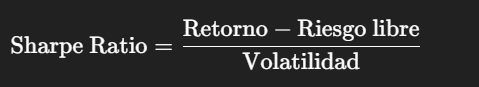

In [18]:
# Calcular Sharpe ex post con retorno futuro y volatilidad futura
data_raw["sharpe_1y"] = (
    (data_raw["target_12m_final"] - data_raw["risk_free_rate"] / 100) / data_raw["volatility_1y"]
)


In [19]:
data_raw.head()

,date,ticker,year_x,trade_date,close_reb_adj,vol_1y,max_1y,min_1y,sma_1y,sma_2y,...,rebalance_date,closeadj,ret_6m,ret_12m,target_12m_shift,next_exit_date,target_12m_final,index,risk_free_rate,sharpe_1y
0,1998-03-31,GWW,1998.0,1998-03-31,32.910,11078200.0,32.974,29.972,31.460607,31.460607,...,1998-03-31,32.910,NaN,NaN,-0.151200,NaN,-0.151200,0,5.6555,-1.053084
1,1998-03-31,FCN1,1998.0,1998-03-31,87.697,54968300.0,90.603,71.356,79.785016,79.785016,...,1998-03-31,87.697,NaN,NaN,NaN,1998-10-02,-0.268789,0,5.6555,-1.319834
2,1998-03-31,FCX,1998.0,1998-03-31,5.788,91016200.0,5.933,3.901,4.454377,4.454377,...,1998-03-31,5.788,NaN,NaN,-0.448860,NaN,-0.448860,0,5.6555,-1.089604
3,1998-03-31,HRB,1998.0,1998-03-31,5.144,84888000.0,5.273,4.323,4.849443,4.849443,...,1998-03-31,5.144,NaN,NaN,0.017691,2020-09-21,0.017691,0,5.6555,-0.144706
4,1998-03-31,SIAL,1998.0,1998-03-31,15.580,54066200.0,17.848,15.397,16.437180,16.437180,...,1998-03-31,15.580,NaN,NaN,-0.207125,2015-11-18,-0.207125,0,5.6555,-0.762508


In [20]:
data_raw.to_csv('../data/data_raw.csv', index=False)

In [21]:
data_raw['date'].unique().tolist()

[Timestamp('1998-03-31 00:00:00'),
 Timestamp('1999-03-31 00:00:00'),
 Timestamp('2000-03-31 00:00:00'),
 Timestamp('2001-03-31 00:00:00'),
 Timestamp('2002-03-31 00:00:00'),
 Timestamp('2003-03-31 00:00:00'),
 Timestamp('2004-03-31 00:00:00'),
 Timestamp('2005-03-31 00:00:00'),
 Timestamp('2006-03-31 00:00:00'),
 Timestamp('2007-03-31 00:00:00'),
 Timestamp('2008-03-31 00:00:00'),
 Timestamp('2009-03-31 00:00:00'),
 Timestamp('2010-03-31 00:00:00'),
 Timestamp('2011-03-31 00:00:00'),
 Timestamp('2012-03-31 00:00:00'),
 Timestamp('2013-03-31 00:00:00'),
 Timestamp('2014-03-31 00:00:00'),
 Timestamp('2015-03-31 00:00:00'),
 Timestamp('2016-03-31 00:00:00'),
 Timestamp('2017-03-31 00:00:00'),
 Timestamp('2018-03-31 00:00:00'),
 Timestamp('2019-03-31 00:00:00'),
 Timestamp('2020-03-31 00:00:00'),
 Timestamp('2021-03-31 00:00:00'),
 Timestamp('2022-03-31 00:00:00'),
 Timestamp('2023-03-31 00:00:00'),
 Timestamp('2024-03-31 00:00:00'),
 Timestamp('2025-03-31 00:00:00')]

In [22]:
data_raw[data_raw["ticker"] == "AXON"]

,date,ticker,year_x,trade_date,close_reb_adj,vol_1y,max_1y,min_1y,sma_1y,sma_2y,...,rebalance_date,closeadj,ret_6m,ret_12m,target_12m_shift,next_exit_date,target_12m_final,index,risk_free_rate,sharpe_1y
13267,2024-03-31,AXON,2024.0,2024-03-28,312.88,168081464.0,319.88,175.73,226.405100,184.771873,...,2024-03-31,312.88,0.572340,0.391505,0.680996,NaN,0.680996,26,4.2062,1.766323
13798,2025-03-31,AXON,2025.0,2025-03-31,525.95,171211871.0,710.01,276.22,441.406195,334.356170,...,2025-03-31,525.95,0.316191,0.680996,NaN,NaN,NaN,27,4.2110,NaN


In [ ]:
ld.close_session()